In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import TweetTokenizer
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import time
pd.set_option('max_colwidth',400)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import torch.utils.data
import random
import warnings
warnings.filterwarnings("ignore", message="F-score is ill-defined and being set to 0.0 due to no predicted samples.")
import re
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

In [2]:
def seed_torch(seed = 1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
train = pd.read_csv("train.csv")
val = pd.read_csv("test.csv")
sub = pd.read_csv('sample_submission.csv')

In [4]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]


def space_punkt(x):
    """Добавляет пробелы до и после знаков пунктуации — это необходимо для дальнейшей токенизации"""
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

mispell_dict = {"aren't" : "are not",
                "can't" : "cannot",
                "couldn't" : "could not",
                "didn't" : "did not",
                "doesn't" : "does not",
                "don't" : "do not",
                "hadn't" : "had not",
                "hasn't" : "has not",
                "haven't" : "have not",
                "he'd" : "he would",
                "he'll" : "he will",
                "he's" : "he is",
                "i'd" : "I would",
                "i'll" : "I will",
                "i'm" : "I am",
                "isn't" : "is not",
                "it's" : "it is",
                "it'll":"it will",
                "i've" : "I have",
                "let's" : "let us",
                "mightn't" : "might not",
                "mustn't" : "must not",
                "shan't" : "shall not",
                "she'd" : "she would",
                "she'll" : "she will",
                "she's" : "she is",
                "shouldn't" : "should not",
                "that's" : "that is",
                "there's" : "there is",
                "they'd" : "they would",
                "they'll" : "they will",
                "they're" : "they are",
                "they've" : "they have",
                "we'd" : "we would",
                "we're" : "we are",
                "weren't" : "were not",
                "we've" : "we have",
                "what'll" : "what will",
                "what're" : "what are",
                "what's" : "what is",
                "what've" : "what have",
                "where's" : "where is",
                "who'd" : "who would",
                "who'll" : "who will",
                "who're" : "who are",
                "who's" : "who is",
                "who've" : "who have",
                "won't" : "will not",
                "wouldn't" : "would not",
                "you'd" : "you would",
                "you'll" : "you will",
                "you're" : "you are",
                "you've" : "you have",
                "'re": " are",
                "wasn't": "was not",
                "we'll":" will",
                "didn't": "did not",
                "tryin'":"trying"}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

train["question_text"] = train["question_text"].apply(lambda x: space_punkt(x.lower()))
val["question_text"] = val["question_text"].apply(lambda x: space_punkt(x.lower()))

train["question_text"] = train["question_text"].apply(lambda x: clean_numbers(x))
val["question_text"] = val["question_text"].apply(lambda x: clean_numbers(x))

train["question_text"] = train["question_text"].apply(lambda x: replace_typical_misspell(x))
val["question_text"] = val["question_text"].apply(lambda x: replace_typical_misspell(x))

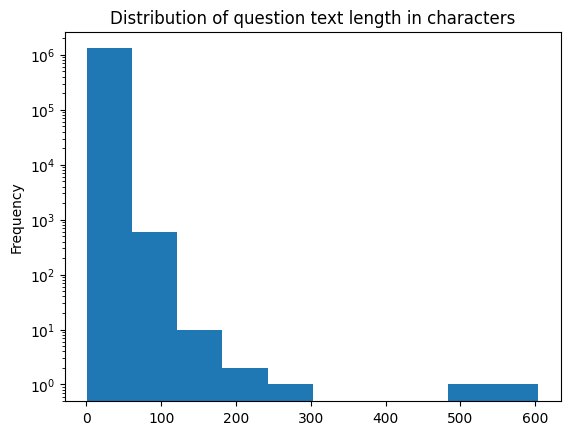

In [5]:
max_features = 120000
tk = Tokenizer(lower = True, filters='', num_words=max_features)
full_text = list(train['question_text'].values) + list(val['question_text'].values)
tk.fit_on_texts(full_text)

train_tokenized = tk.texts_to_sequences(train['question_text'].fillna('missing'))
val_tokenized = tk.texts_to_sequences(val['question_text'].fillna('missing'))

train['question_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in characters');

In [7]:
max_len = 603
X_train = pad_sequences(train_tokenized, maxlen = max_len)
X_val = pad_sequences(val_tokenized, maxlen = max_len)
X_train

array([[    0,     0,     0, ...,     2,  1590,     1],
       [    0,     0,     0, ...,    54,  1843,     1],
       [    0,     0,     0, ...,   471,  5302,     1],
       ...,
       [    0,     0,     0, ..., 11277,  2923,     1],
       [    0,     0,     0, ...,  3411,   433,     1],
       [    0,     0,     0, ...,     5, 20274,     1]], dtype=int32)

In [8]:
y_train = train['target'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_train)

In [10]:
embed_size = 300
embedding_path = "embeddings/glove.840B.300d/glove.840B.300d.txt"
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore'))
# all_embs = np.stack(embedding_index.values())
# emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std = -0.005838499, 0.48782197
word_index = tk.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [11]:
embedding_path = "embeddings/paragram_300_sl999/paragram_300_sl999.txt"
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore') if len(o)>100)
# all_embs = np.stack(embedding_index.values())
# emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std = -0.0053247833, 0.49346462
embedding_matrix1 = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix1[i] = embedding_vector

In [12]:
embedding_matrix = np.mean([embedding_matrix, embedding_matrix1], axis=0)
del embedding_matrix1

In [14]:
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_train, dtype=torch.long)
y_test = torch.tensor(y_train, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.long)

train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)
val = torch.utils.data.TensorDataset(X_val)
batch_size = 256
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size)

C:\Users\krum1\AppData\Local\Temp\ipykernel_27084\1979542758.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_train, dtype=torch.long)
C:\Users\krum1\AppData\Local\Temp\ipykernel_27084\1979542758.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_train, dtype=torch.float32)


In [15]:
X_test

tensor([[   0,    0,    0,  ...,   72,  279,    1],
        [   0,    0,    0,  ...,  738, 2364,    1],
        [   0,    0,    0,  ...,   56,  162,    1],
        ...,
        [   0,    0,    0,  ...,    8, 1430,    1],
        [   0,    0,    0,  ...,   16,  694,    1],
        [   0,    0,    0,  ...,   90,  342,    1]])

In [16]:
import torch
import torch.nn as nn

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()

        hidden_size = 128
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # Замораживаем веса эмбеддингов
        
        self.embedding_dropout = nn.Dropout(0.1)
        
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        
        self.linear = nn.Linear(hidden_size * 4, 16)  # hidden_size * 4 = avg_pool + max_pool
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.bn = nn.BatchNorm1d(16)
        self.out = nn.Linear(16, 1)
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm, _ = self.lstm(h_embedding)
        
        avg_pool = torch.mean(h_lstm, 1)  
        max_pool, _ = torch.max(h_lstm, 1) 
        
        conc = torch.cat((avg_pool, max_pool), 1)

        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        conc = self.bn(conc)
        out = self.out(conc)
        
        return out

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = batch_size
from tqdm import tqdm
model = NeuralNet().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters())
best_f1 = 0
for epoch in range(10):
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []

    for x_batch, y_batch in tqdm(train_loader):
        x_batch, y_batch = x_batch.to(device).long(), y_batch.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        
        y_pred = model(x_batch)
        
        loss = loss_fn(y_pred, y_batch)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item() / len(train_loader)

        probs = torch.sigmoid(y_pred)
        pred_labels = (probs > 0.5).float()
        all_train_preds.extend(pred_labels.cpu().numpy())
        all_train_labels.extend(y_batch.cpu().numpy())
    
    all_train_labels = np.array(all_train_labels).flatten()
    all_train_preds = np.array(all_train_preds).flatten()

    precision_train = precision_score(all_train_labels, all_train_preds)
    recall_train = recall_score(all_train_labels, all_train_preds)
    f1_train = f1_score(all_train_labels, all_train_preds)
    print(f"Эпоха {epoch+1}")
    print(f"Train loss: {train_loss}")
    print(f"Train Precision: {precision_train:.4f} | Train Recall: {recall_train:.4f} | Train F1 Score: {f1_train:.4f}")

    
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device).long(), y_val.to(device).unsqueeze(1)
            preds = model(x_val)
            loss = loss_fn(preds, y_val)
            val_loss += loss.item() / len(test_loader)

            probs = torch.sigmoid(preds) 
            pred_labels = (probs > 0.5).float()
            all_preds.extend(pred_labels.cpu().numpy()) 
            all_labels.extend(y_val.cpu().numpy()) 

    all_labels = np.array(all_labels).flatten()
    all_preds = np.array(all_preds).flatten()

    precision_val = precision_score(all_labels, all_preds)
    recall_val = recall_score(all_labels, all_preds)
    f1_val = f1_score(all_labels, all_preds)
    
    print(f"Validation loss: {val_loss:.4f}")
    print(f"Validation Precision: {precision_val:.4f} | Validation Recall: {recall_val:.4f} | Validation F1 Score: {f1_val:.4f}")
    if f1_val > best_f1:
        best_f1 = f1_val
        torch.save(model.state_dict(), "best_model.pth")
    
    val_preds = np.zeros((len(val_loader.dataset)))

    for i, (x_batch,) in enumerate(val_loader):
        x_batch = x_batch.to(device).long()
        y_pred = model(x_batch).detach()
    

        val_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]


100%|██████████████████████████████████████████████████████████████████████████████| 4082/4082 [04:13<00:00, 16.08it/s]


Эпоха 1
Train loss: 0.14053418244281266
Train Precision: 0.6314 | Train Recall: 0.4745 | Train F1 Score: 0.5418
Validation loss: 0.0984
Validation Precision: 0.7447 | Validation Recall: 0.5571 | Validation F1 Score: 0.6374


100%|██████████████████████████████████████████████████████████████████████████████| 4082/4082 [04:18<00:00, 15.77it/s]


Эпоха 2
Train loss: 0.10908841398681016
Train Precision: 0.7096 | Train Recall: 0.5161 | Train F1 Score: 0.5976
Validation loss: 0.0911
Validation Precision: 0.7184 | Validation Recall: 0.6768 | Validation F1 Score: 0.6970


100%|██████████████████████████████████████████████████████████████████████████████| 4082/4082 [04:18<00:00, 15.79it/s]


Эпоха 3
Train loss: 0.10365186387190248
Train Precision: 0.7216 | Train Recall: 0.5411 | Train F1 Score: 0.6185
Validation loss: 0.0860
Validation Precision: 0.7538 | Validation Recall: 0.6667 | Validation F1 Score: 0.7076


100%|██████████████████████████████████████████████████████████████████████████████| 4082/4082 [04:15<00:00, 16.00it/s]


Эпоха 4
Train loss: 0.09900199267091504
Train Precision: 0.7265 | Train Recall: 0.5663 | Train F1 Score: 0.6365
Validation loss: 0.0804
Validation Precision: 0.8061 | Validation Recall: 0.6121 | Validation F1 Score: 0.6959


100%|██████████████████████████████████████████████████████████████████████████████| 4082/4082 [04:18<00:00, 15.77it/s]


Эпоха 5
Train loss: 0.09392330356559189
Train Precision: 0.7413 | Train Recall: 0.5933 | Train F1 Score: 0.6591
Validation loss: 0.0751
Validation Precision: 0.8146 | Validation Recall: 0.6602 | Validation F1 Score: 0.7293


100%|██████████████████████████████████████████████████████████████████████████████| 4082/4082 [04:12<00:00, 16.20it/s]


Эпоха 6
Train loss: 0.08714440161164269
Train Precision: 0.7484 | Train Recall: 0.6276 | Train F1 Score: 0.6827
Validation loss: 0.0694
Validation Precision: 0.7485 | Validation Recall: 0.8125 | Validation F1 Score: 0.7792


100%|██████████████████████████████████████████████████████████████████████████████| 4082/4082 [04:11<00:00, 16.22it/s]


Эпоха 7
Train loss: 0.08186870127312175
Train Precision: 0.7626 | Train Recall: 0.6662 | Train F1 Score: 0.7111
Validation loss: 0.0634
Validation Precision: 0.8434 | Validation Recall: 0.7173 | Validation F1 Score: 0.7752


100%|██████████████████████████████████████████████████████████████████████████████| 4082/4082 [04:17<00:00, 15.85it/s]


Эпоха 8
Train loss: 0.07795902378838897
Train Precision: 0.7725 | Train Recall: 0.6849 | Train F1 Score: 0.7260
Validation loss: 0.0590
Validation Precision: 0.8371 | Validation Recall: 0.7735 | Validation F1 Score: 0.8040


100%|██████████████████████████████████████████████████████████████████████████████| 4082/4082 [04:16<00:00, 15.92it/s]


Эпоха 9
Train loss: 0.07562868941633702
Train Precision: 0.7776 | Train Recall: 0.6907 | Train F1 Score: 0.7315
Validation loss: 0.0574
Validation Precision: 0.7982 | Validation Recall: 0.8580 | Validation F1 Score: 0.8270


100%|██████████████████████████████████████████████████████████████████████████████| 4082/4082 [04:16<00:00, 15.88it/s]


Эпоха 10
Train loss: 0.07297235867578951
Train Precision: 0.7801 | Train Recall: 0.7005 | Train F1 Score: 0.7381
Validation loss: 0.0558
Validation Precision: 0.8289 | Validation Recall: 0.8549 | Validation F1 Score: 0.8417


In [20]:
sub['prediction'] = (val_preds > 0.5).astype(int)
sub.to_csv("submission.csv", index=False)